In [ ]:
import numpy as np
import math
import perceval as pcvl

## Impementing CNOT

Per (Ralp, PhysRev 2007, PhysRevA.75.022313) paper

### Deterministic polarization encoded


<img src="image-20240204-110219.png" width="" align="" />

In [ ]:
p_cnot = pcvl.catalog["heralded cnot"].build_processor()

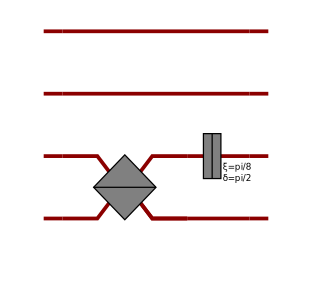

In [ ]:
p = pcvl.Processor("SLOS", 4)  # 4th mode should be always initialized as empty!
p.add(2, pcvl.PBS())
p.add(2, pcvl.WP(delta=np.pi/2, xsi=np.pi/8)) # HWP at xsi = 22.5 deg


pcvl.pdisplay(p)


**Conclusion: this is impossible to implement here, since we cannot do CZ gate in polarization encoding, as they do on fig. 3 on the right**


<img src="image-20240204-111544.png" width="" align="" />

### Non deterministic post selection implementation


<img src="image-20240204-111706.png" width="50%" align="" />

#### Beamsplitter test

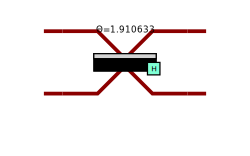

In [ ]:
p = pcvl.Processor("SLOS", 2)
p.add((0,1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
pcvl.pdisplay(p)

In [ ]:
p.with_input(pcvl.BasicState([1,0]))
sampler = pcvl.algorithm.Sampler(p)
samples = sampler.samples(100)
print(sampler.sample_count(100))

{'results': BSCount(<class 'int'>, {|1,0>: 34, |0,1>: 66}), 'physical_perf': 1, 'logical_perf': 1}


#### Postselection

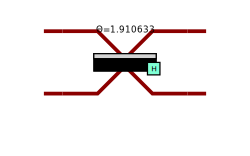

In [ ]:
post_selector = pcvl.PostSelect("[0] == 1")

p = pcvl.Processor("SLOS", 2)
p.add((0,1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
p.set_postselection(post_selector)
pcvl.pdisplay(p)

In [ ]:
p.with_input(pcvl.BasicState([1,0]))
sampler = pcvl.algorithm.Sampler(p)
samples = sampler.samples(100)
print(sampler.sample_count(100))

{'results': BSCount(<class 'int'>, {|1,0>: 100}), 'physical_perf': 1, 'logical_perf': 0.33333333333333337}


#### Putting things together Toffoli-sign gate

<img src="image-20240204-111706.png" width="50%" align="" />

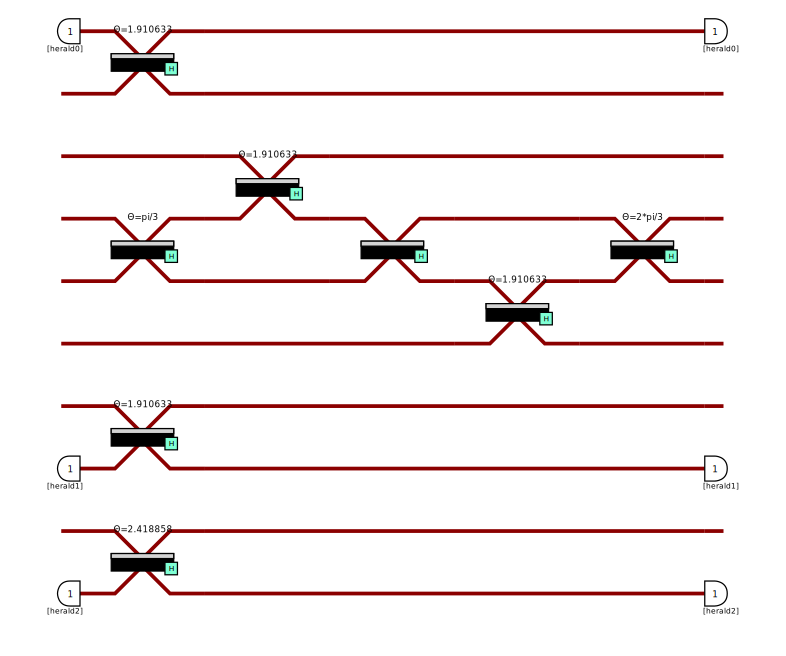

In [ ]:
p = pcvl.Processor("SLOS", 10)



p.add((0,1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
# p.set_postselection(pcvl.PostSelect("[0] == 1"))
p.add_herald(0, expected=1)

p.add((3,4), pcvl.BS.H(pcvl.BS.r_to_theta(3/4)))

p.add((2,3), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))

p.add((3,4), pcvl.BS.H(pcvl.BS.r_to_theta(1/2)))

p.add((4,5), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))

p.add((3,4), pcvl.BS.H(pcvl.BS.r_to_theta(1/4)))
p.set_postselection(pcvl.PostSelect("[4] == 1"))
# p.add_herald(4, expected=1)

p.add((6,7), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
# p.set_postselection(pcvl.PostSelect("[7] == 1"))
p.add_herald(7, expected=1)

p.add((8,9), pcvl.BS.H(pcvl.BS.r_to_theta(1/8)))
# p.set_postselection(pcvl.PostSelect("[9] == 1"))
p.add_herald(9, expected=1)

p.set_postselection(pcvl.PostSelect("[1,2]==1 & [3, 8]==1 & [5,6]==1"))

pcvl.pdisplay(p)

In [ ]:
#               [1,2, 3,4, 5,6, 8]
pcvl.BasicState([1,0, 1,0, 1,0, 0]) # 000
pcvl.BasicState([0, 1,0, 0, 0, 1,0, 0, 1, 0]) # 001

states = {#     [1,2, 3,4, 5,6, 8].   CCT
pcvl.BasicState([1,0, 1,0, 1,0, 0]): "000",
pcvl.BasicState([1,0, 0,0, 1,0, 1]): "001",
pcvl.BasicState([1,0, 1,0, 0,1, 0]): "010",
pcvl.BasicState([1,0, 0,0, 0,1, 1]): "011",
pcvl.BasicState([0,1, 1,0, 1,0, 0]): "100",
pcvl.BasicState([0,1, 0,0, 1,0, 1]): "101",
pcvl.BasicState([0,1, 1,0, 0,1, 0]): "110",
pcvl.BasicState([0,1, 0,0, 0,1, 1]): "111",
}

ca = pcvl.algorithm.Analyzer(p, states)
pcvl.pdisplay(ca, precision=1e-3)

,000,001,010,011,100,101,110,111
000,1,0,0,0,0,0,0,0
001,0,1,0,0,0,0,0,0
010,0,0,1,0,0,0,0,0
011,0,0,0,1,0,0,0,0
100,0,0,0,0,1,0,0,0
101,0,0,0,0,0,1,0,0
110,0,0,0,0,0,0,1,0
111,0,0,0,0,0,0,0,1


In [ ]:
#                            [1,2, 3,4, 5,6, 8]
p.with_input(pcvl.BasicState([1,0, 1,0, 1,0, 0]))
sampler = pcvl.algorithm.Sampler(p)
samples = sampler.samples(1000)
print(sampler.sample_count(1000))

{'results': BSCount(<class 'int'>, {|1,0,1,0,1,0,0>: 1000}), 'physical_perf': 1, 'logical_perf': 0.00019290123456756382}


In [ ]:
#               [0, 1,2, 3, 4, 5,6, 7, 8, 9]
pcvl.BasicState([0, 1,0, 1, 0, 1,0, 0, 0, 0]) # 000
pcvl.BasicState([0, 1,0, 0, 0, 1,0, 0, 1, 0]) # 001

states = {
pcvl.BasicState([0, 1,0, 1, 0, 1,0, 0, 0, 0]): "000",
pcvl.BasicState([0, 1,0, 0, 0, 1,0, 0, 1, 0]): "001"
}

ca = pcvl.algorithm.Analyzer(p, states)
pcvl.pdisplay(ca, precision=1e-3)

In [ ]:
#                            [0, 1,2, 3, 4, 5,6, 7, 8, 9]
p.with_input(pcvl.BasicState([0, 1,0, 0, 1, 1,0, 0, 1, 0]))
sampler = pcvl.algorithm.Sampler(p)
samples = sampler.samples(1000)
print(sampler.sample_count(1000))

### Toffoli gate
Assume that first qubit is target (contratry to previous notation). This change is due to that last qubit is actually a qutrit and everything should be the same otherwise.

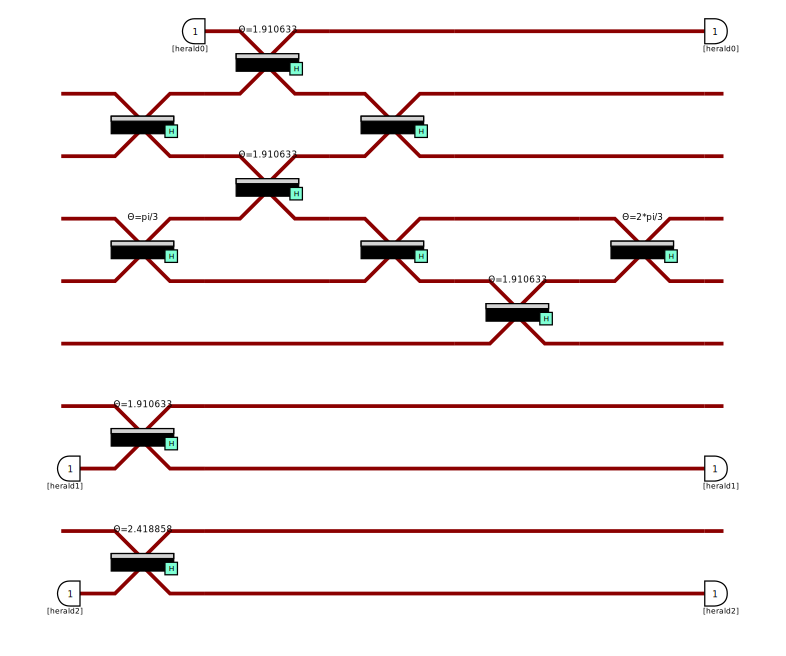

In [ ]:
p = pcvl.Processor("Naive", 10)

# Hadamard on target before
p.add((1,2), pcvl.BS.H())
# p.add((3,8), pcvl.BS.H())


p.add((0,1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
# p.set_postselection(pcvl.PostSelect("[0] == 1"))
p.add_herald(0, expected=1)

p.add((3,4), pcvl.BS.H(pcvl.BS.r_to_theta(3/4)))

p.add((2,3), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))

p.add((3,4), pcvl.BS.H(pcvl.BS.r_to_theta(1/2)))

p.add((4,5), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))

p.add((3,4), pcvl.BS.H(pcvl.BS.r_to_theta(1/4)))
p.set_postselection(pcvl.PostSelect("[4] == 1"))
# p.add_herald(4, expected=1)

p.add((6,7), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
# p.set_postselection(pcvl.PostSelect("[7] == 1"))
p.add_herald(7, expected=1)

p.add((8,9), pcvl.BS.H(pcvl.BS.r_to_theta(1/8)))
# p.set_postselection(pcvl.PostSelect("[9] == 1"))
p.add_herald(9, expected=1)

# Hadamard on target after
p.add((1,2), pcvl.BS.H())
# p.add((3, 8), pcvl.BS.H())

p.set_postselection(pcvl.PostSelect("[1,2]==1 & [3, 8]==1 & [5,6]==1"))

pcvl.pdisplay(p)

In [ ]:
#               [1,2, 3,4, 5,6, 8]
pcvl.BasicState([1,0, 1,0, 1,0, 0]) # 000
pcvl.BasicState([0, 1,0, 0, 0, 1,0, 0, 1, 0]) # 001

# states = {#     [1,2, 3,4, 5,6, 8].   CCT
# pcvl.BasicState([1,0, 1,0, 1,0, 0]): "000",
# pcvl.BasicState([1,0, 0,0, 1,0, 1]): "001",
# pcvl.BasicState([1,0, 1,0, 0,1, 0]): "010",
# pcvl.BasicState([1,0, 0,0, 0,1, 1]): "011",
# pcvl.BasicState([0,1, 1,0, 1,0, 0]): "100",
# pcvl.BasicState([0,1, 0,0, 1,0, 1]): "101",
# pcvl.BasicState([0,1, 1,0, 0,1, 0]): "110",
# pcvl.BasicState([0,1, 0,0, 0,1, 1]): "111",
# }
states = {#     [1,2, 3,4, 5,6, 8].   TCC
pcvl.BasicState([1,0, 1,0, 1,0, 0]): "000",
pcvl.BasicState([1,0, 0,0, 1,0, 1]): "001",
pcvl.BasicState([0,1, 0,0, 1,0, 1]): "101",
pcvl.BasicState([0,1, 1,0, 1,0, 0]): "100",
pcvl.BasicState([0,1, 0,0, 0,1, 1]): "111",
pcvl.BasicState([1,0, 0,0, 0,1, 1]): "011",
pcvl.BasicState([0,1, 1,0, 0,1, 0]): "110",
pcvl.BasicState([1,0, 1,0, 0,1, 0]): "010",
}

ca = pcvl.algorithm.Analyzer(p, states)
pcvl.pdisplay(ca, precision=1e-3)
print(f"performance = {ca.performance}")

,000,001,101,100,111,011,110,010
000,1,0,0,0,0,0,0,0
001,0,1,0,0,0,0,0,0
101,0,0,1,0,0,0,0,0
100,0,0,0,1,0,0,0,0
111,0,0,0,0,1,0,0,0
011,0,0,0,0,0,1,0,0
110,0,0,0,0,0,0,0,1
010,0,0,0,0,0,0,1,0


performance = 0.0001929012345677503


## Old/not organized code

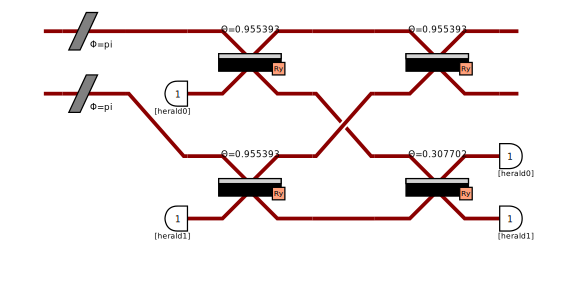

In [ ]:
p = pcvl.Processor("SLOS", 4)
p.add(0, pcvl.PS(np.pi))
p.add(1, pcvl.PS(np.pi))
p.add((0,2), pcvl.BS.Ry(theta=(54.74/180)*np.pi))
p.add((2,3), pcvl.BS.Ry(theta=(54.74/180)*np.pi))
p.add((0,2), pcvl.BS.Ry(theta=(54.74/180)*np.pi))
p.add((2,3), pcvl.BS.Ry(theta=(17.63/180)*np.pi))
p.add_herald(2, 1)
p.add_herald(3, 1)


pcvl.pdisplay(p)

In [ ]:
states = {
    pcvl.BasicState([0,0]): "00",
    pcvl.BasicState([0,1]): "01",
    pcvl.BasicState([1, 0]): "10",
    pcvl.BasicState([1, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(p, states)
ca.compute(expected={"00": "00", "01": "01", "10": "10", "11": "11"})
pcvl.pdisplay(ca, precision=1e-1)
print(f"performance = {pcvl.simple_float(ca.performance)[1]}, fidelity = {ca.fidelity*100}%")

,00,01,10,11
00,1,0,0,0
01,0,sqrt(3)/2,0,0
10,0,0,sqrt(3)/2,0
11,0,0,0,1


performance = 0.11107, fidelity = (93.7334741814985+0j)%


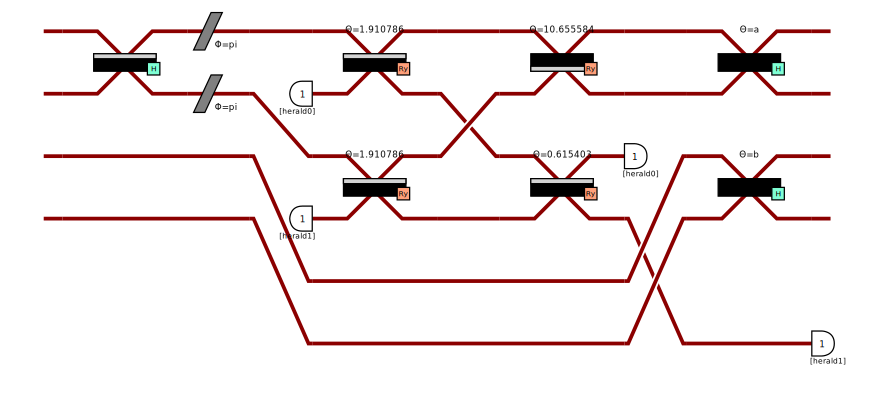

In [ ]:
source = pcvl.Source(emission_probability=0.40, multiphoton_component=0.01)

QPU = pcvl.Processor("SLOS", 4, source)
QPU.add(0, pcvl.BS.H())
QPU.add(0, p)

a = pcvl.Parameter("a")
b = pcvl.Parameter("b")

QPU.add(0, pcvl.BS.H(theta=a)) #Beam splietter at 0 Qubit
QPU.add(2, pcvl.BS.H(theta=b))

pcvl.pdisplay(QPU, recursive=True)

In [ ]:
a.set_value(0)
b.set_value(0)
QPU.with_input(pcvl.BasicState([1, 0, 1, 0]))

In [ ]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-4)

state,probability
"|0,0,0,0,0,0>",0.1296
"|0,0,0,0,0,{_:0}>",0.0862
"|0,0,0,0,{_:0},0>",0.0862
"|0,0,{_:0},0,0,0>",0.0862
"|{_:0},0,0,0,0,0>",0.0862
"|0,0,0,0,{_:0},{_:0}>",0.0574
"|0,0,{_:0},0,0,{_:0}>",0.0574
"|0,0,{_:0},0,{_:0},0>",0.0574
"|{_:0},0,0,0,0,{_:0}>",0.0574
"|{_:0},0,0,0,{_:0},0>",0.0574


In [ ]:
output_distribution=QPU.probs()["results"]
pcvl.pdisplay(output_distribution, max_v=10)

state,probability
"|1,0,1,0>",0.485243
"|0,1,1,0>",0.484667
"|0,0,2,0>",0.011386
"|1,1,0,0>",0.004788
"|0,2,0,0>",0.003775
"|1,1,1,0>",0.003181
"|0,2,1,0>",0.002512
"|2,0,0,0>",0.001531
"|2,0,1,0>",0.001019
"|0,1,2,0>",0.000952573


In [ ]:
from tqdm.auto import tqdm
import numpy as np

x = np.arange(0, 20, 0.5)
y = []

for g2 in tqdm(x):
    Es = []
    for va in [0, math.pi/2]:
        a.set_value(va)
        for vb in [math.pi/4, 3*math.pi/4]:
            b.set_value(vb)
            Npp, Npm, Nmp, Nmm = 0, 0, 0, 0
            QPU.source = pcvl.Source(emission_probability=.15, multiphoton_component=g2/100)
            QPU.with_input(pcvl.BasicState([1, 0, 1, 0]))  # with_input has to be called everytime you change a source
            output_distribution = QPU.probs()["results"]
            for output_state, prob in output_distribution.items():
                if (output_state[0] == 1 and output_state[2] == 1):
                    Npp = prob
                if (output_state[0] == 1 and output_state[3] == 1):
                    Npm = prob
                if (output_state[1] == 1 and output_state[2] == 1):
                    Nmp = prob
                if (output_state[1] == 1 and output_state[3] == 1):
                    Nmm = prob
            E = (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
            Es.append(E)

    S = Es[0]-Es[1]+Es[2]+Es[3]
    print(f"g2 = {g2/100}, S = {S}")
    y.append(S)

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  5%|▌         | 2/40 [00:00<00:02, 18.53it/s]g2 = 0.0, S = 0.0008667226926598603
g2 = 0.005, S = -0.0004829810494475506
g2 = 0.01, S = 0.003399570317855316
 15%|█▌        | 6/40 [00:00<00:02, 12.56it/s]g2 = 0.015, S = -0.0013720680438518151
g2 = 0.02, S = 0.004234346376564058
g2 = 0.025, S = -0.0007447689672130942
 20%|██        | 8/40 [00:00<00:02, 12.19it/s]g2 = 0.03, S = 0.0016238434374024058
g2 = 0.035, S = 0.0017461890364245392
g2 = 0.04, S = -0.0007907062395795528
 30%|███       | 12/40 [00:01<00:02, 11.02it/s]g2 = 0.045, S = -0.027364148370789154
g2 = 0.05, S = -0.029909094341069253
g2 = 0.055, S = -0.015247545566653531
 35%|███▌      | 14/40 [00:01<00:02, 10.99it/s]g2 = 0.06, S = -0.01630752214600506
g2 = 0.065, S = -0.017

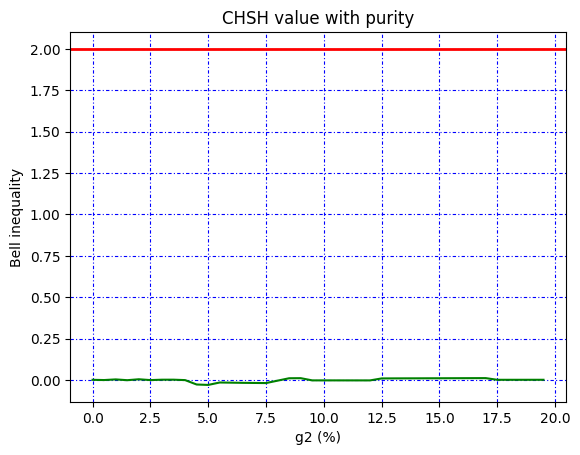

In [ ]:
import matplotlib.pyplot as plt
plt.title("CHSH value with purity")
plt.xlabel("g2 (%)")
plt.ylabel("Bell inequality")
plt.axhline(y=2, linewidth=2, color="red", label='horizontal-line')
plt.plot(x, y, color ="green")
plt.grid(color='b', dashes=(3, 2, 1, 2))
plt.show()

In [ ]:
process_test=pcvl.Processor("SLOS",2)
process_test.add(0,pcvl.BS(0))
processor_test.measure([0,1],[0,1])

AttributeError: 'Processor' object has no attribute 'measure'

,00,01,10,11
00,1,0,0,0
01,0,sqrt(3)/2,0,0
10,0,0,sqrt(3)/2,0
11,0,0,0,2/3


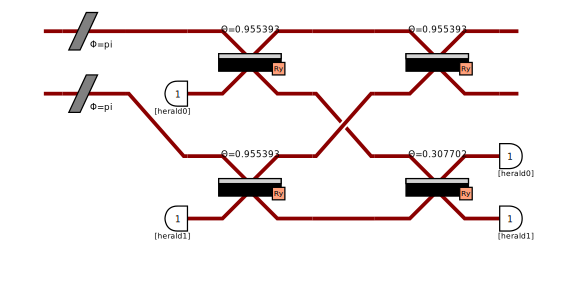

In [ ]:
states = {
    pcvl.BasicState([0,0]): "00",
    pcvl.BasicState([0,1]): "01",
    pcvl.BasicState([1, 0]): "10",
    pcvl.BasicState([1, 1]): "11"
}
ca = pcvl.algorithm.Analyzer(p, states)
# ca.compute(expected={"00": "00", "01": "01", "10": "10", "11": "11"})
pcvl.pdisplay(ca, precision=1e-1)
pcvl.pdisplay(p)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf459061-b6f2-46d3-a468-64cb2414fb56' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>